# Bank account fraud detection
Daniel Mizrahi (10675418), Antonio La Chira Marquina (11847018)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from data_analysis import *
from read_data import read_dataset
from classifiers import *
from performance import *


from sklearn.metrics import *

## Reading the data
We first start off by reading in the data. Since some of the data is categorical and therefore non-numerical we must use one hot encoding to process the data and make sure this won't be a problem when implenting our classifiers such logistic regression. Altough perhaps marginal when converting categorical data we drop the first column so there is less data later on to perform calculations on. The original data without one hot encoding can be used to perform analysis and make conclusions about the data and for Naive Bayes classifiers.

In [5]:
data_original = read_dataset('datasets/Base.csv', process=False)
data = read_dataset('datasets/Base.csv', process=True, drop_first=True)

In [3]:
print('Preview of the one hot encoded data in table form (first 10 rows and 4 columns):')
print(data.head(10).iloc[:, :4])

print(f'\nOrignal data shape (rows, columns): {data_original.shape}')
print(f'One hot encoded data shape (rows, columns): {data.shape}')

Preview of the one hot encoded data in table form (first 10 rows and 4 columns):
   fraud_bool  income  name_email_similarity  prev_address_months_count
0           1     0.9               0.166828                         -1
1           1     0.9               0.296286                         -1
2           1     0.9               0.044985                         -1
3           1     0.9               0.159511                         -1
4           1     0.9               0.596414                         -1
5           1     0.3               0.143921                         -1
6           1     0.7               0.321554                         -1
7           1     0.9               0.064817                         -1
8           1     0.7               0.065938                         -1
9           1     0.9               0.700096                         -1

Orignal data shape (rows, columns): (1000000, 32)
One hot encoded data shape (rows, columns): (1000000, 47)


## Visualization of data
### Visualization of all data
We visualize the raw (original) dataset by plotting histograms and bar charts for each column in the dataframe.
Note that this is all the data, no distinction has been made yet in fraudulent vs non-fraudulent data.
Since there are essentially three types of information in the dataset we split the data into categorical data, boolean data and other (continuous?) data and adjust the plot for each type accordingly.

This visualization allows us to speculate about the possible underlying distributions for the data by column.

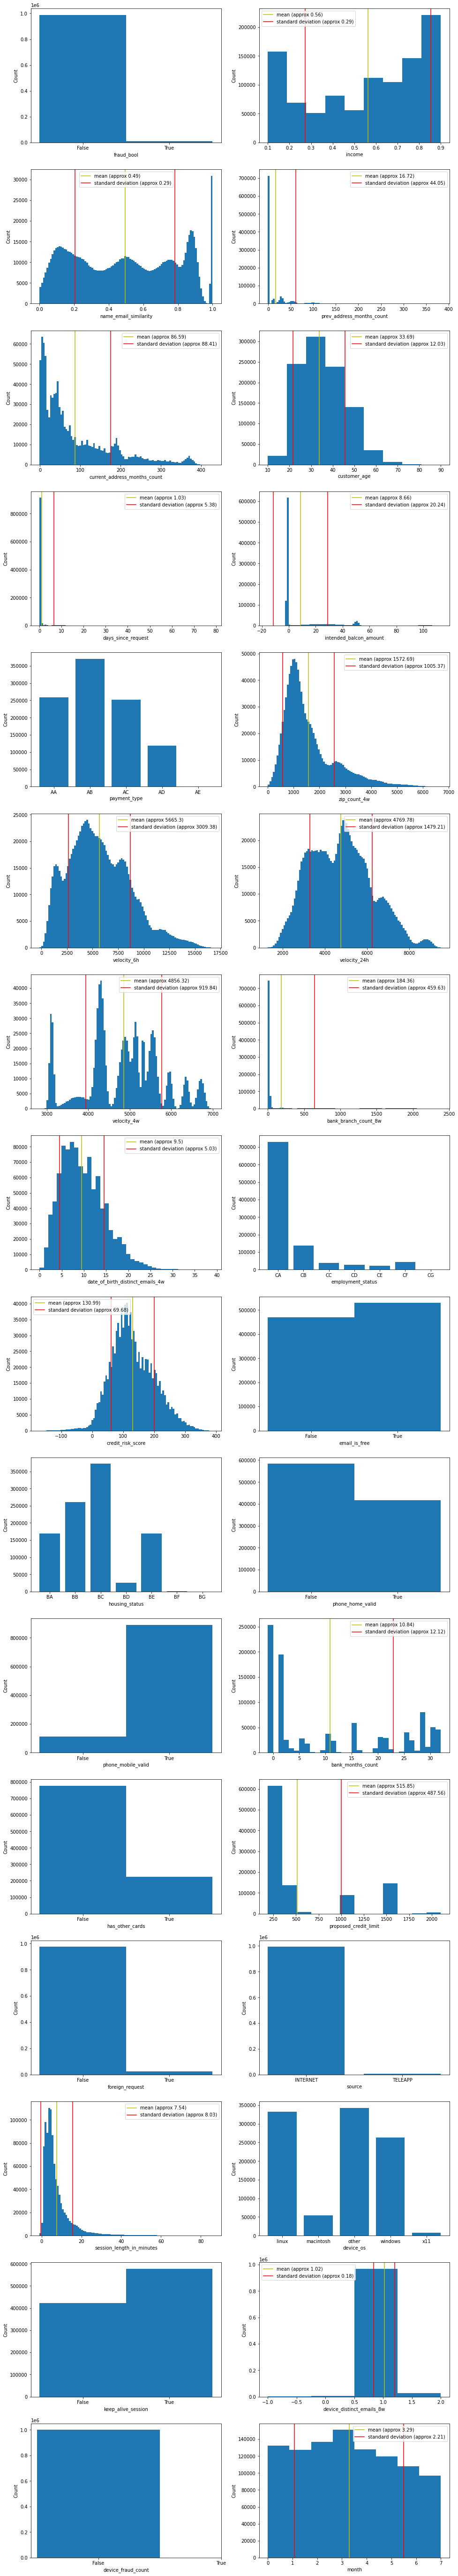

In [4]:
# k = 'auto'
k = 100

categorical_data = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
boolean_data = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
                'foreign_request', 'keep_alive_session', 'device_fraud_count']

fig, axs = plt.subplots(16, 2, figsize=(16,100))
column_names = list(data_original.columns.values)
for column, ax in enumerate(axs.flat):
    ax.set_xlabel(column_names[column])
    ax.set_ylabel('Count')
    if column_names[column] in boolean_data:
        labels, counts = np.unique(data_original.iloc[:, column], return_counts=True)
        ax.bar(labels, counts, width=1)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['False', 'True'])
    elif column_names[column] in categorical_data:
        labels, counts = np.unique(data_original.iloc[:, column], return_counts=True)
        ax.bar(labels, counts)
    else:
        unique_values = data_original.iloc[:, column].unique().size
        ax.hist(data_original.iloc[:, column], unique_values if unique_values < k else k)
    if column_names[column] not in categorical_data + boolean_data:
        mean = np.mean(data_original.iloc[:, column])
        standard_deviation = np.std(data_original.iloc[:, column])
        ax.axvline(mean, color='y')
        if mean - standard_deviation > np.amin(data_original.iloc[:, column]):
            ax.axvline(mean - standard_deviation, color='r')
        ax.axvline(mean + standard_deviation, color='r')
        ax.legend([f'mean (approx {round(mean, 2)})', f'standard deviation (approx {round(standard_deviation, 2)})'])

### Visualization of data seperated by fraud and non fraud
We create histograms/bar charts for all columns in the dataframe similar to what we did previously except for these plots we separate the data by fraudulent and non-fraudulent data. Additionally the histograms/bar charts are normalized by the number of rows.

The normalization in this case is important because the number of non-fraudulent data entries is about 980k which is much larger than the number of fraudulent data entries which is roughly 20k. Normalization allows us to better compare the behaviours of the underlying distributions per category.

This visualization allows us to speculate about the differences between fraudulent/non-fraudulent entries and all other parameters such as 'fraud vs credit risk score' and 'no fraud vs credit risk score'. Visual inspection alone already shows in some cases the distributions of fraud and non fraud can be quite different. Others not so much but further analysis might show different.

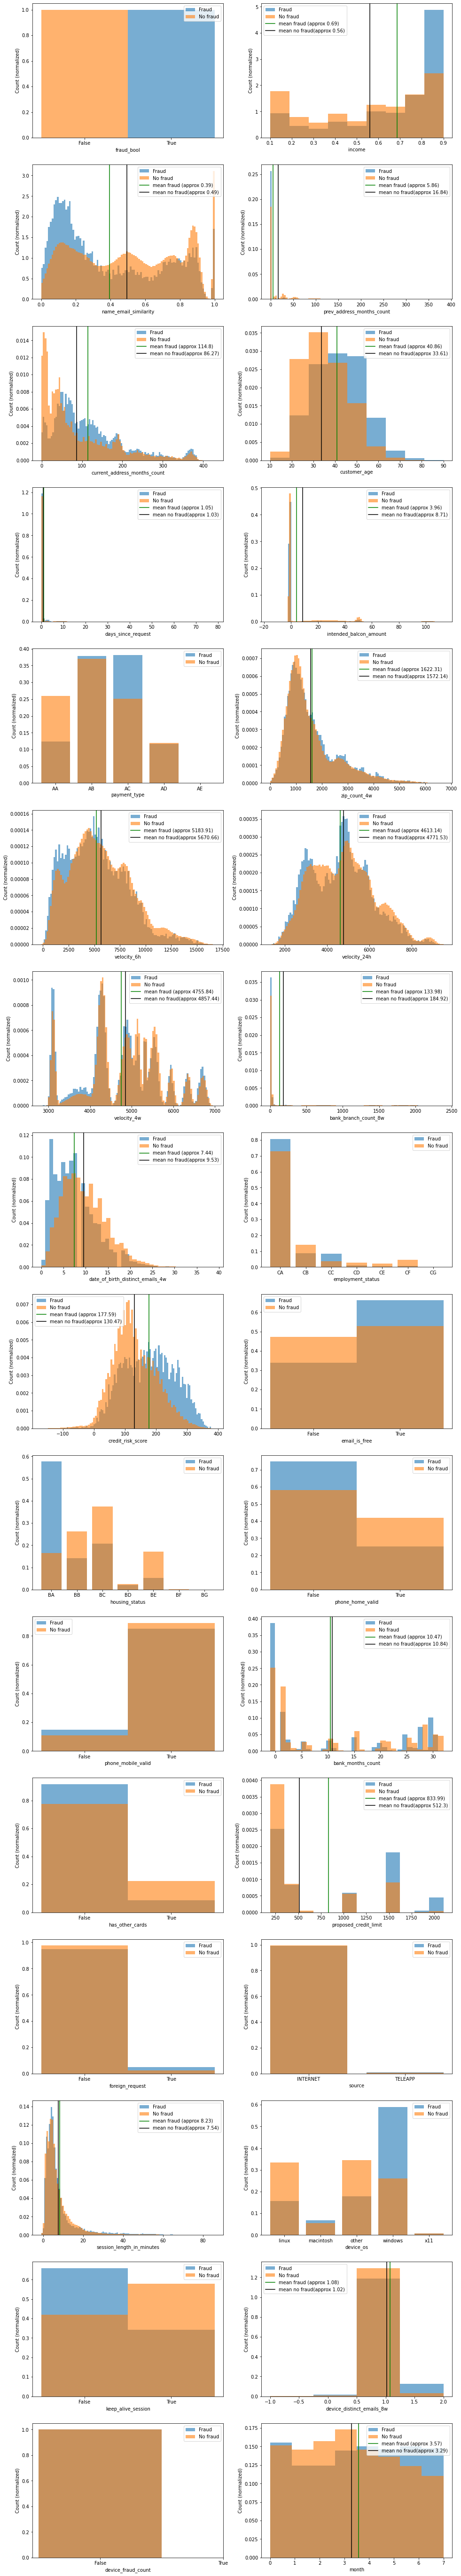

In [5]:
# k = 'auto'
k = 100

categorical_data = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
boolean_data = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
                'foreign_request', 'keep_alive_session', 'device_fraud_count']

data_fraud = data_original.loc[data_original['fraud_bool'] == 1]
data_no_fraud = data_original.loc[data_original['fraud_bool'] == 0]

fig, axs = plt.subplots(16, 2, figsize=(16,100))
column_names = list(data_original.columns.values)
for column, ax in enumerate(axs.flat):
    ax.set_xlabel(column_names[column])
    ax.set_ylabel('Count (normalized)')
    if column_names[column] in boolean_data:
        lbls_f, cts_f = np.unique(data_fraud.iloc[:, column], return_counts=True)
        lbls_nf, cts_nf = np.unique(data_no_fraud.iloc[:, column], return_counts=True)
        ax.bar(lbls_f, cts_f / len(data_fraud.iloc[:, column]), width=1, label='Fraud', alpha=.6)
        ax.bar(lbls_nf, cts_nf / len(data_no_fraud.iloc[:, column]), width=1, label='No fraud', alpha=.6)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['False', 'True'])
    elif column_names[column] in categorical_data:
        lbls_f, cts_f = np.unique(data_fraud.iloc[:, column], return_counts=True)
        lbls_nf, cts_nf = np.unique(data_no_fraud.iloc[:, column], return_counts=True)
        ax.bar(lbls_f, cts_f / len(data_fraud.iloc[:, column]), label='Fraud', alpha=.6)
        ax.bar(lbls_nf, cts_nf / len(data_no_fraud.iloc[:, column]), label='No fraud', alpha=.6)
    else:
        unique_values = len(set(data_fraud.iloc[:, column].unique()) | set(data_no_fraud.iloc[:, column].unique()))
        ax.hist(data_fraud.iloc[:, column], unique_values if unique_values < k else k, label='Fraud', density=True, alpha=.6)
        ax.hist(data_no_fraud.iloc[:, column], unique_values if unique_values < k else k, label='No fraud', density=True, alpha=.6)
    ax.legend()
    if column_names[column] not in categorical_data + boolean_data:
        handles, labels = ax.get_legend_handles_labels()
        mean_f = np.mean(data_fraud.iloc[:, column])
        mean_nf = np.mean(data_no_fraud.iloc[:, column])
        mn_f = ax.axvline(mean_f, color='g')
        mn_nf = ax.axvline(mean_nf, color='k')
        ax.legend(handles + [mn_f, mn_nf], labels + [f'mean fraud (approx {round(mean_f, 2)})', f'mean no fraud(approx {round(mean_nf, 2)})'])

## Similarity and differences of variables between fraudulent and nonfraudulent
### Bootstrap test for mean and standard deviation
Altough as mentioned visual inspection alone already shows a distribution between fraud and non fraud can be quite different other seems not so much. By bootstrapping random values of every variable to create a dataset of the same size as the fraud dataset we can show how significant the distributions differ are by already only looking at the mean and standard deviation. Plots also include CI's for $\alpha = 0.05$ . Almost all have $p$-values of $0.0$.

The hypothesis is then: \
$H_0$: The mean and/or standard deviation of a fraudulent dataset is equal tot a nonfraudulent dataset

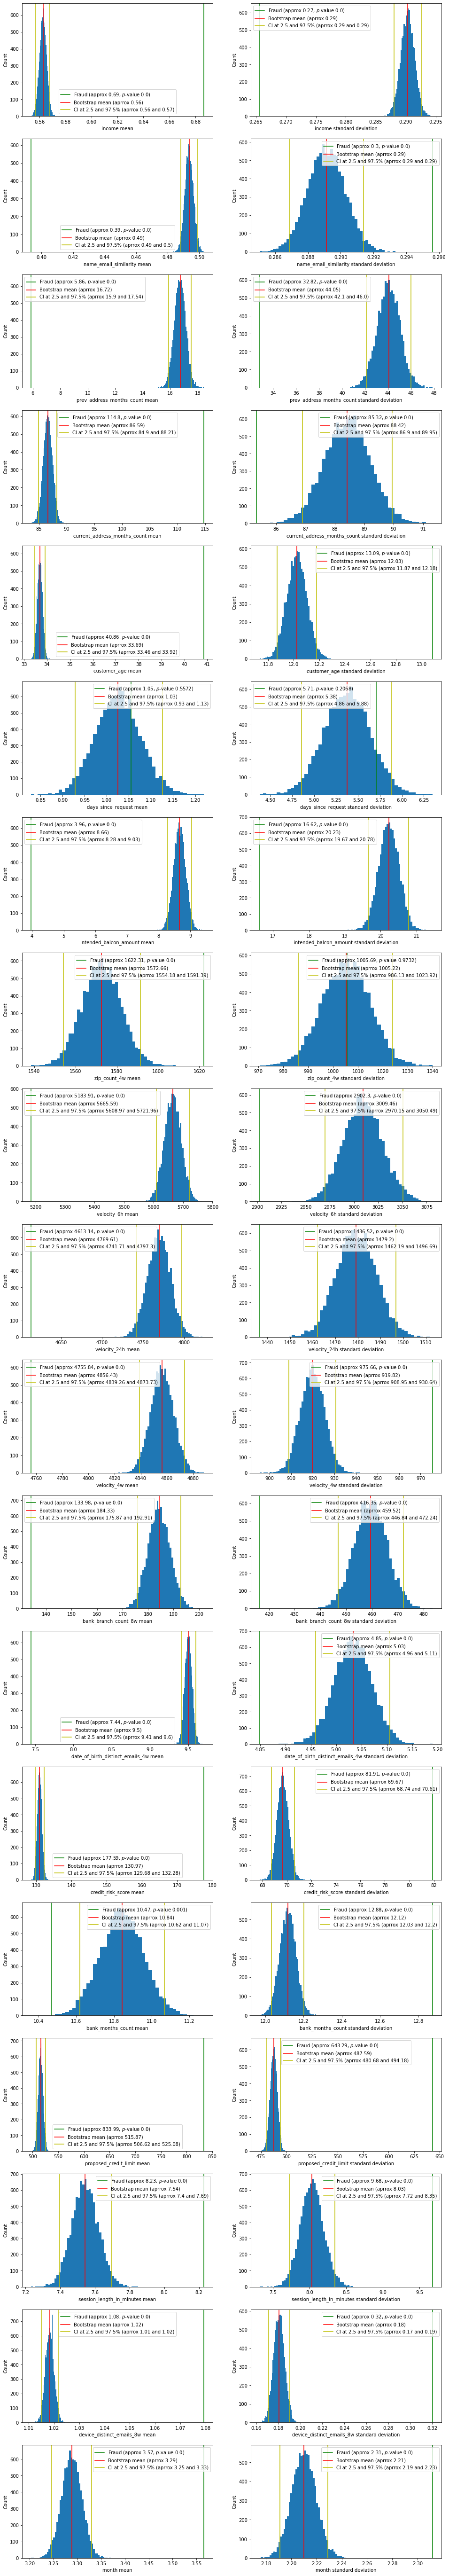

In [7]:
data_fraud = data_original.loc[data_original['fraud_bool'] == 1]
size = data_fraud.shape[0]
iterations = 10000
categorical_data = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
boolean_data = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
                'foreign_request', 'keep_alive_session', 'device_fraud_count']
columns_exclude = categorical_data + boolean_data
test = bootstrap_mean_standard_deviation(data_original, data_fraud, size, iterations, columns_exclude=columns_exclude)

k = 50
fig, axs = plt.subplots(len(test), 2, figsize=(16,100))
for column, ax in enumerate(axs.flat):
    ax.set_xlabel(test[int(column / 2)][0] + (' standard deviation' if column % 2 else ' mean'))
    ax.set_ylabel('Count')
    ax.hist(test[int(column / 2)][1 + column % 2], k)
    fraud_statistic = data_fraud[test[int(column / 2)][0]].std() if column % 2 else data_fraud[test[int(column / 2)][0]].mean()
    bootstrap_mean = np.mean(test[int(column / 2)][1 + column % 2])
    confidence_intervals = np.percentile(test[int(column / 2)][1 + column % 2], [2.5, 97.5])
    ax.axvline(fraud_statistic, color='g')
    ax.axvline(bootstrap_mean, color='r')
    ax.axvline(confidence_intervals[0], color='y')
    ax.axvline(confidence_intervals[1], color='y')
    ax.legend([f'Fraud (approx {round(fraud_statistic, 2)}, $p$-value {test[int(column / 2)][3 + column % 2]})',
               f'Bootstrap mean (aprrox {round(bootstrap_mean, 2)})',
               f'CI at 2.5 and 97.5% (aprrox {round(confidence_intervals[0], 2)} and {round(confidence_intervals[1], 2)})'])

Looking at the mean and standard deviation difference between fraudulant and non fraudulant data alone already seems to indicate with confidence that they are distributed differently. Atleast according to the parameters of a distribution. The "shape" of a distribution could also additionally differ (e.g. one is normal and the other beta). The only exception seems to be days_since_request. For all other distibutions the null hypothesis can be rejected.

### Kolmogorov-Smirnov and Epps-Singleton test for distribution similarity
By using the Kolmogorov-Smirnov we can calculate how similar two samples are. Note that the two-sample test checks whether the two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal). The test gives us a KS-statistic (1.0 means complete dissimilarity and 0.0 complete similarity) and a $p$-value.

The Epps-Singleton test also calculates how similar two samples are. The test gives us a ES-statistic (lower means more similar) and a $p$-value.

If we choose $\alpha = 0.05$ no two distributions fraud and non fraud are similar enough to be considered drawn from the same distribution.

In both cases the hypothesis is: \
$H_0$: The 2 samples are drawn from the same distribution.

In [8]:
continuous_data = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count',
                   'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
                   'velocity_4w', 'bank_branch_count_8w', 'credit_risk_score', 'bank_months_count',
                   'session_length_in_minutes']

data_fraud = data.loc[data['fraud_bool'] == 1]
data_no_fraud = data.loc[data['fraud_bool'] == 0]

ks_statistics = kolmogorov_smirnov_similarity(data_fraud[continuous_data], data_no_fraud[continuous_data])
ep_statistics = epps_singleton_similarity(data_fraud[continuous_data], data_no_fraud[continuous_data])
ks_most_similar = np.argsort(ks_statistics[:, 0])
ep_most_similar = np.argsort(ep_statistics[:, 0])

ks_table = list()
for column in ks_most_similar:
    ks_table.append([data[continuous_data].columns[column], ks_statistics[column][0], ks_statistics[column][1]])
print(pd.DataFrame(ks_table, columns=['Variable', 'KS statistic', 'p-value']))
print()

ep_table = list()
for column in ep_most_similar:
    ep_table.append([data[continuous_data].columns[column], ep_statistics[column][0], ep_statistics[column][1]])
print(pd.DataFrame(ep_table, columns=['Variable', 'EP statistic', 'p-value']))

                        Variable  KS statistic        p-value
0      session_length_in_minutes      0.027042   2.313200e-07
1                   zip_count_4w      0.036626   3.786793e-13
2                   velocity_24h      0.047764   4.602355e-22
3                    velocity_6h      0.063211   2.493909e-38
4             days_since_request      0.069237   6.583571e-46
5                    velocity_4w      0.071602   4.519496e-49
6              bank_months_count      0.123097  1.690072e-144
7         intended_balcon_amount      0.143678  6.122341e-197
8           bank_branch_count_8w      0.166462  1.273924e-264
9          name_email_similarity      0.185558   0.000000e+00
10     prev_address_months_count      0.208227   0.000000e+00
11                        income      0.215356   0.000000e+00
12  current_address_months_count      0.262601   0.000000e+00
13             credit_risk_score      0.263764   0.000000e+00

                        Variable  EP statistic        p-value
0      

Although some distribution seems to be more similar than others of all can said with confidence they are not similar. The null hypothesis can be rejected in all cases.

### Pearson and Spearman correlation
By calculating Pearson and Spearman correlations between the variables and especially bool_fraud and the rest. We could possibly determine which variables are more relevant for it to be fraudulent. It should be noted that pearson correlation is sensitive to non normal data. Data which later on will be shown that almost all are non normal. So statistics generated by Pearson should be taken with a grain of salt. Also Spearman also takes nonlinear correlation into consideration. The $p$-values of Pearson is also influenced by normality so we will ignore that. Spearman's $p$-value on the otherhand expresses the chance both samples are uncorrelated. We choose $\alpha = 0.05$.

So the hypothesis for Spearman is: \
$H_0$: The two sets of data are uncorrelated

Additionaly only the correlation between bool_fraud and the rest is printed out in text format.

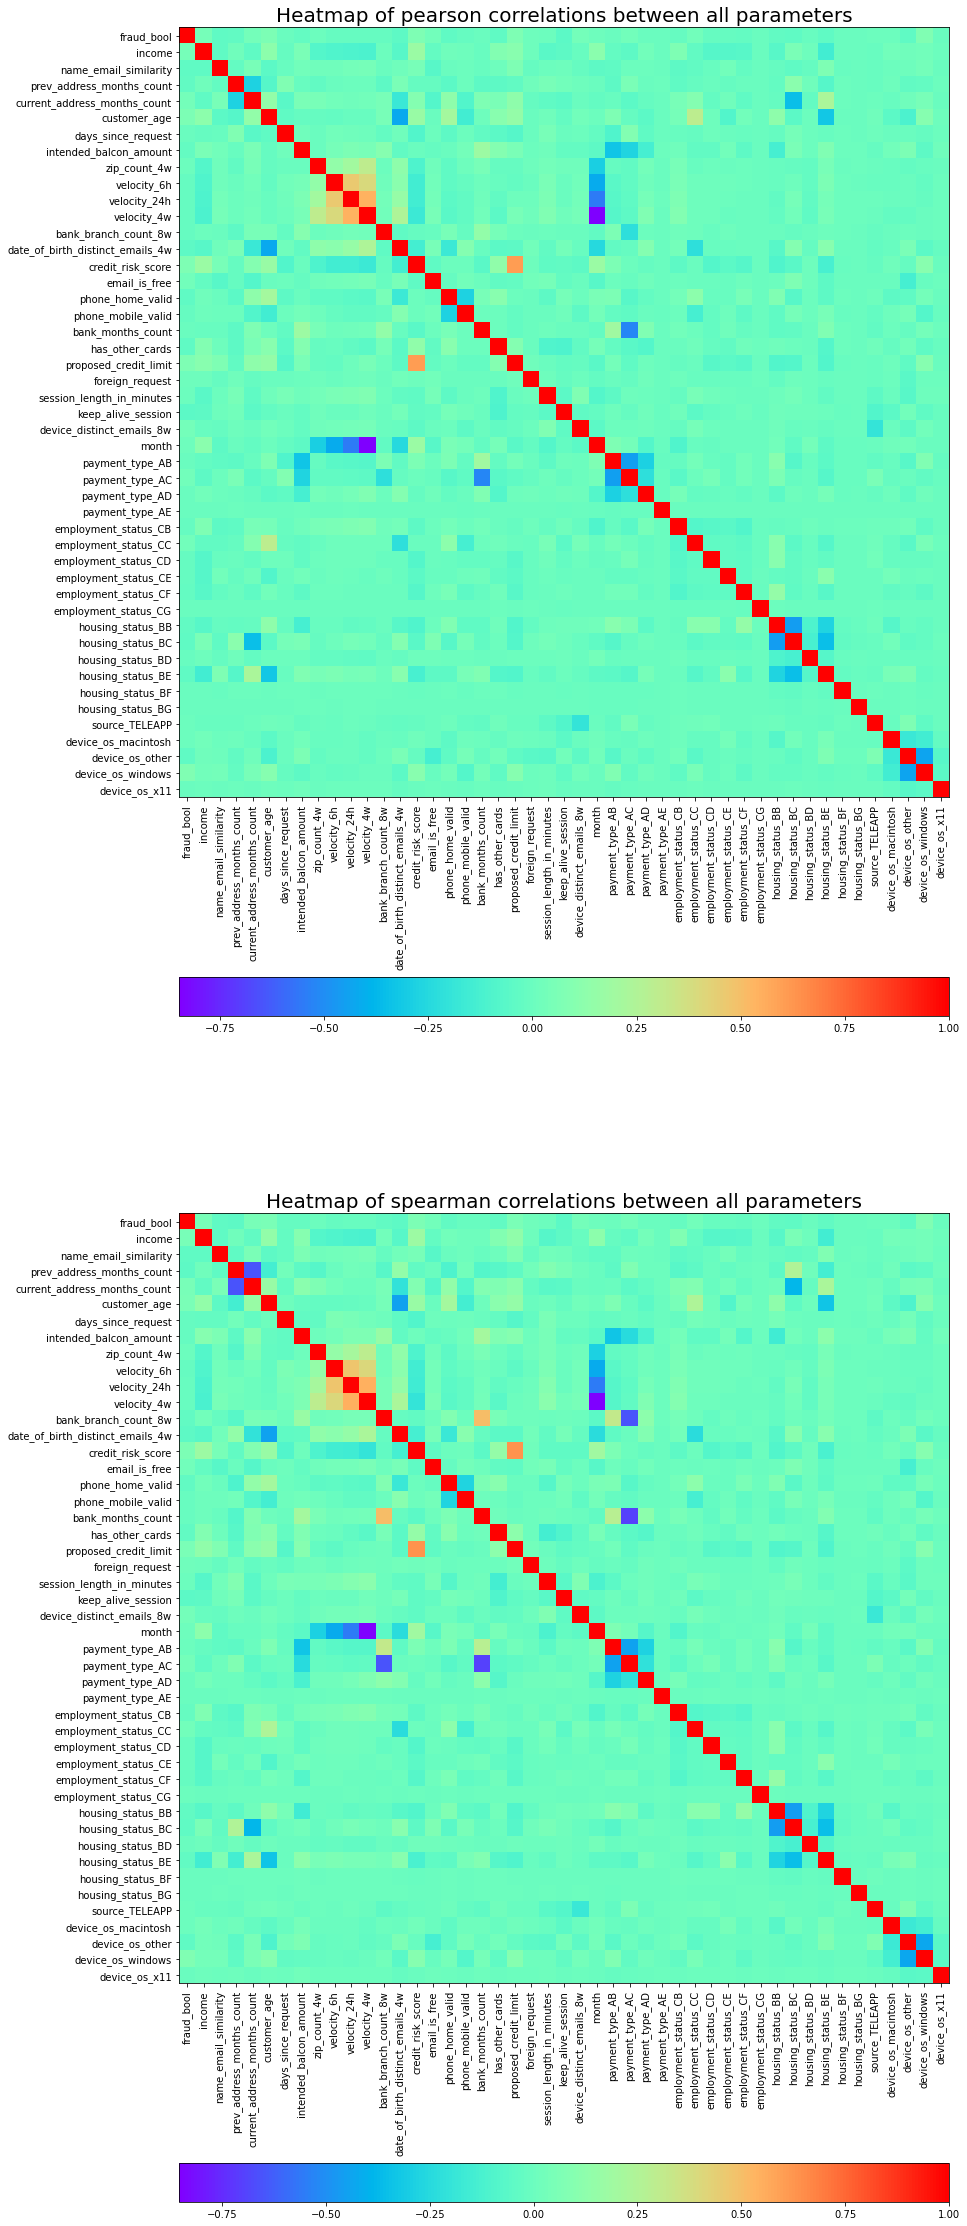

                            Variable   Pearson        p-value
0                         fraud_bool  1.000000   0.000000e+00
1                             income  0.045079   0.000000e+00
2              name_email_similarity -0.036720  2.255505e-295
3          prev_address_months_count -0.026031  1.985831e-149
4       current_address_months_count  0.033701  4.022082e-249
5                       customer_age  0.062959   0.000000e+00
6                 days_since_request  0.000567   5.705248e-01
7             intended_balcon_amount -0.024524  7.408217e-133
8                       zip_count_4w  0.005212   1.868284e-07
9                        velocity_6h -0.016892   5.019689e-64
10                      velocity_24h -0.011183   4.921883e-29
11                       velocity_4w -0.011536   8.687409e-31
12              bank_branch_count_8w -0.011577   5.397590e-31
13  date_of_birth_distinct_emails_4w -0.043224   0.000000e+00
14                 credit_risk_score  0.070624   0.000000e+00
15      

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

pearson_correlations = pearson_correlation_coefficient(data)
spearman_correlations = spearman_correlation_coefficient(data)

fig, ax = plt.subplots(2, 1, figsize=(24,40))

hm_p = ax[0].imshow(np.array(pearson_correlations), cmap=plt.cm.rainbow)
hm_s = ax[1].imshow(np.array(spearman_correlations), cmap=plt.cm.rainbow)

ax[0].set_title('Heatmap of pearson correlations between all parameters', fontsize=20)
ax[0].set_xticks(np.arange(len(data.columns)))
ax[0].set_yticks(np.arange(len(data.columns)))

ax[0].set_xticklabels(data.columns, rotation=90)
ax[0].set_yticklabels(data.columns)

ax[1].set_title('Heatmap of spearman correlations between all parameters', fontsize=20)
ax[1].set_xticks(np.arange(len(data.columns)))
ax[1].set_yticks(np.arange(len(data.columns)))

ax[1].set_xticklabels(data.columns, rotation=90)
ax[1].set_yticklabels(data.columns)

# Add axes underneath both subplots
div1 = make_axes_locatable(ax[0])
div2 = make_axes_locatable(ax[1])

cax1 = div1.new_vertical(size='5%', pad=2.5, pack_start=True)
cax2 = div2.new_vertical(size='5%', pad=2.5, pack_start=True)

fig.add_axes(cax1)
fig.add_axes(cax2)

fig.colorbar(hm_p, cax=cax1, orientation='horizontal')
fig.colorbar(hm_s, cax=cax2, orientation='horizontal')

plt.show()

pearson_table = list()
spearman_table = list()
for column in data.columns:
    pearson_correlations = pearson_correlation_coefficient(np.array(data['fraud_bool']), np.array(data[column]))
    spearman_correlations = spearman_correlation_coefficient(np.array(data['fraud_bool']), np.array(data[column]))
    pearson_table.append([column, pearson_correlations[0], pearson_correlations[1]])
    spearman_table.append([column, spearman_correlations[0], spearman_correlations[1]])
print(pd.DataFrame(pearson_table, columns=['Variable', 'Pearson', 'p-value']))
print()
print(pd.DataFrame(spearman_table, columns=['Variable', 'Spearman', 'p-value']))

It seems it can be safely said there is some correlation between fraud_bool and the rest except for some payment_types.

## Fitting distributions
By fitting types distributions we can further our understanding of the data. Just assuming everything is normal will not suffice. Also this information can be used to build a better Naive Bayes implementation than the one provided by for example sklearn. A number of distributions are tried using MLE. $p$-values are generated for every fit using the Kolmogor-Smirnov test and the best one is plotted (the best fit can still have a $p$ value of around $0.0$).

The null hypothesis is then: \
$H_0$: The data is drawn from distribution X*

\* The distribution is shown in the plot.

In all cases the best distribution found seems to be better than other distributions but the null hypothesis is still rejected.

c:\program files\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
c:\program files\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
c:\program files\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
c:\program files\python38\lib\site-packages\scipy\stats\_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\program files\python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\program files\python38\lib\site-packages\scipy\stats\_distn_infr

IndexError: index 19 is out of bounds for axis 0 with size 19

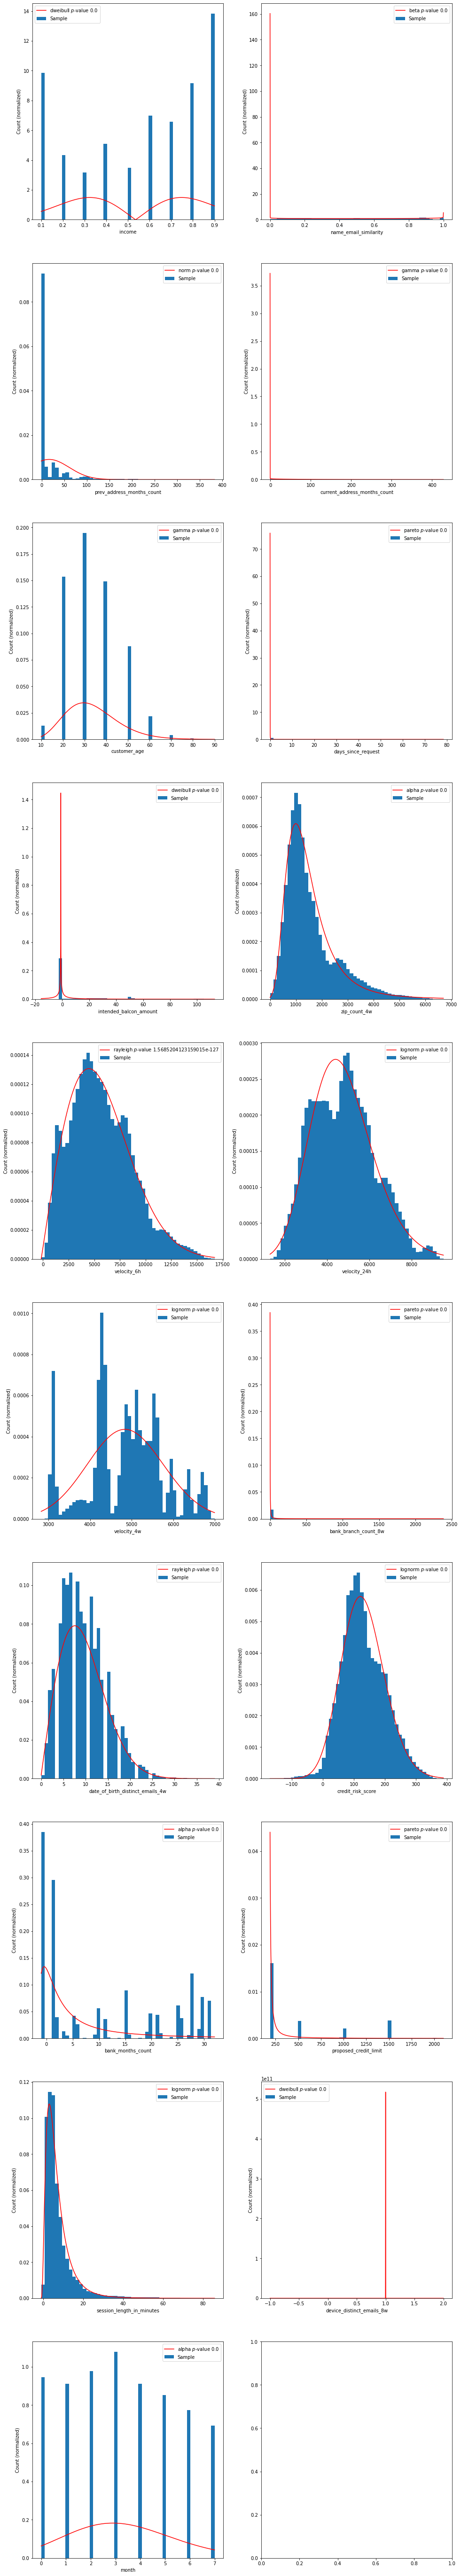

In [10]:
categorical_data = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
boolean_data = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
                'foreign_request', 'keep_alive_session', 'device_fraud_count']

data_fraud = data_original.loc[data_original['fraud_bool'] == 1]
data_no_fraud = data_original.loc[data_original['fraud_bool'] == 0]

distributions_consider = ['alpha', 'beta', 'cosine', 'gamma', 'pareto', 'rayleigh', 'norm', 'lognorm', 'dweibull']

continuous_data = list()
for column in data_original.columns:
    if data_original[column].nunique() >= 3 and data_original[column].dtypes != object:
        continuous_data.append(column)

k = 50
fig, axs = plt.subplots(int(len(continuous_data) / 2) + 1, 2, figsize=(16,100))
for column, ax in enumerate(axs.flat):
    try:
        ax.set_xlabel(data_original[continuous_data].columns[column])
    except IndexError:
        continue
    ax.set_ylabel('Count (normalized)')
    ax.hist(data_original[continuous_data].iloc[:, column], k, density=True)
    best_distribution = find_distribution(data_original[continuous_data].iloc[:, column], distributions_consider)
    x = np.linspace(np.amin(data_original[continuous_data].iloc[:, column]),
                    np.amax(data_original[continuous_data].iloc[:, column]), 1000)
    args = best_distribution[1][:-2]
    y = None
    if args:
        y = getattr(stats, best_distribution[0]).pdf(x, *args, loc=best_distribution[1][-2],
                                                     scale=best_distribution[1][-1])
    else:
        y = getattr(stats, best_distribution[0]).pdf(x, loc=best_distribution[1][-2],
                                                     scale=best_distribution[1][-1])
    ax.plot(x, y, color='r')
    ax.legend([f'{best_distribution[0]} $p$-value {best_distribution[2][1]}', 'Sample'])

## Classifiers
### Multi Naive Bayes
Like the Naive Bayes classifier from sklearn our customer Multi Naive Bayes classifier uses Bayesian statistics
to classify. The Gaussian sklearn version assumes all distributions are distributed according to a Gaussian distribution. This custom implementation does not. It uses the find_distritution function from to find the best distribution for every feature. For distributions which are boolean a Bernoulli distribution is used. And for
distributions which are categorical the same probility function is used as the one in sklearn: https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes. With the same alpha value of 1.0. It must be noted as with the find_distribution function training this model requires significant more computation than a simple Naive Bayes from sklearn.

Our hope is fitting correct distributions to every feature will improve performance according to metrics like precision recall accuracy and f1. We will bootstrap the sklearn Gaussian NB a 1000 times with random training and tests sets. The sizes though will stay fixed: 70/30. To make comparison fair only continuous data is considered for classification. Gaussian sklearn will perform bad and our multi version can accommodate boolean and categorical data correctly. We chose $\alpha = 0.05$ one tailed. A CI is included in the plot.


$H_0$: Multi Naive Bayes is not better than Naive Bayes

[0.8 0.7 0.9 ... 0.9 0.9 0.6]


c:\program files\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
c:\program files\python38\lib\site-packages\scipy\stats\_continuous_distns.py:707: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


[0.42626954 0.12890354 0.24680593 ... 0.08142351 0.14319971 0.77888199]
[-1. -1. -1. ... -1. -1. -1.]


c:\program files\python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[ 95.  98. 103. ... 112.  67. 214.]
[40. 50. 40. ... 40. 50. 40.]
[1.05861567e-04 1.22557006e-03 4.30807879e-03 ... 2.00995095e-02
 3.03086056e-02 8.02976825e+00]
[101.04318953  -0.9800965   -1.33704741 ...  -1.32682051  -0.37915809
  35.34680686]
[1299. 1766. 1103. ... 2347.  711.  881.]
[12258.24153259  6683.04856514 10361.18323505 ...  7599.84356803
  2226.28712651  3472.0437848 ]
[6059.59658613 5682.62412499 4802.45277895 ... 5233.57694724 5224.93509021
 6106.92196153]
[6646.62407103 6769.19984503 5271.24569851 ... 5084.49450359 4230.66552622
 5477.52264943]
[  1.  28.   0. ...   0.   0. 931.]


c:\program files\python38\lib\site-packages\scipy\stats\_continuous_distns.py:7273: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()


[7. 2. 3. ... 7. 5. 3.]
[142. 119. 267. ...  68. 204.  21.]
[ 2. 31. -1. ... -1. 28. 10.]
[ 200.  500. 1500. ...  200.  500.  200.]
[8.78082191 4.82530944 1.02989473 ... 3.76200582 7.10527416 6.97239715]
[1. 1. 1. ... 1. 1. 1.]
[4. 0. 5. ... 3. 5. 1.]
[0.8 0.3 0.1 ... 0.4 0.8 0.5]
[0.4831007  0.51252327 0.53649555 ... 0.63320585 0.76113123 0.14421097]
[13. -1. -1. ... -1. -1. 35.]
[ 11. 118. 356. ... 186. 193.  17.]
[20. 20. 50. ... 50. 20. 40.]
[0.01297704 0.02051503 0.02290788 ... 0.03004409 0.01306625 0.01378209]
[-1.31543154 -0.13552306 -1.33423058 ... 49.12603169  9.04090422
 32.36142458]
[2384. 1391. 1043. ... 2467. 2840. 1745.]
[ 7962.24571105  6114.24965306  5182.65316375 ...  2511.90270791
 12960.37638764  2670.50756019]
[6103.93356056 4394.92372306 3213.01195258 ... 3100.5970312  8094.08809809
 4205.08849763]
[4771.3128254  5394.04037184 4848.29981202 ... 4168.06673652 6705.00824041
 4359.21388815]
[0.000e+00 1.000e+00 0.000e+00 ... 1.800e+01 1.475e+03 1.622e+03]
[21. 13.  3.

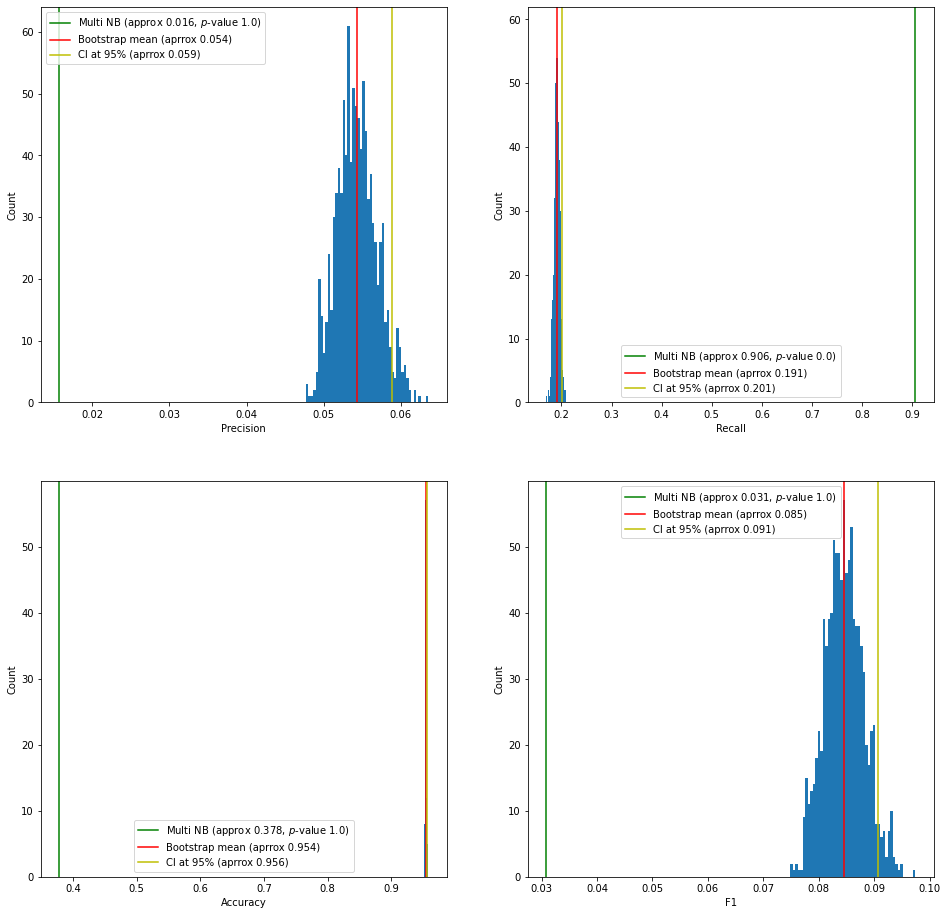

In [6]:
continuous_data = list()
for column in data_original.columns:
    if data_original[column].nunique() >= 3 and data_original[column].dtypes != object:
        continuous_data.append(column)
continuous_data = ['fraud_bool'] + continuous_data

precisions = list()
recalls = list()
accuracies = list()
f1s = list()
iterations = 1000
for _ in range(iterations):
    i_row_train = np.random.choice(data_original[continuous_data].shape[0],
                               data_original[continuous_data].shape[0] * 70 // 100, replace=False)
    i_row_test = np.array(list(set(np.arange(data_original[continuous_data].shape[0])) - set(i_row_train)))
    target_sample = data_original[continuous_data].values[i_row_train, 0]
    train_sample = data_original[continuous_data].values[i_row_train, 1:]
    test_sample = data_original[continuous_data].values[i_row_test, 1:]
    test_target = data_original[continuous_data].values[i_row_test, 0]
    clf_nb = NaiveBayesClassifier()
    clf_nb.fit(train_sample, target_sample)
    test_prediction = clf_nb.predict(test_sample)
    precisions.append(precision_score(test_target, test_prediction))
    recalls.append(recall_score(test_target, test_prediction))
    accuracies.append(accuracy_score(test_target, test_prediction))
    f1s.append(f1_score(test_target, test_prediction))
scores = [precisions, recalls, accuracies, f1s]

distributions_consider = ['alpha', 'beta', 'cosine', 'gamma', 'pareto', 'rayleigh', 'norm', 'lognorm', 'dweibull']
i_row_train = np.random.choice(data_original[continuous_data].shape[0],
                               data_original[continuous_data].shape[0] * 70 // 100, replace=False)
i_row_test = np.array(list(set(np.arange(data_original[continuous_data].shape[0])) - set(i_row_train)))
target_sample = data_original[continuous_data].values[i_row_train, 0]
train_sample = data_original[continuous_data].values[i_row_train, 1:]
test_sample = data_original[continuous_data].values[i_row_test, 1:]
test_target = data_original[continuous_data].values[i_row_test, 0]
clf_mnb = MultiNaiveBayesClassifier(distributions_consider=distributions_consider)
clf_mnb.fit(train_sample, target_sample)
multi_test_prediction = clf_mnb.predict(test_sample)

multi_precision = precision_score(test_target, multi_test_prediction)
multi_recall = recall_score(test_target, multi_test_prediction)
multi_accuracy = accuracy_score(test_target, multi_test_prediction)
multi_f1 = f1_score(test_target, multi_test_prediction)
scores_multi = [multi_precision, multi_recall, multi_accuracy, multi_f1]
score_names = ['Precision', 'Recall', 'Accuracy', 'F1']
k = 50
fig, axs = plt.subplots(2, 2, figsize=(16,16))
for score, ax in enumerate(axs.flat):
    ax.set_xlabel(score_names[score])
    ax.set_ylabel('Count')
    ax.hist(scores[score], k)
    bootstrap_mean = np.mean(scores[score])
    confidence_interval = np.percentile(scores[score], 95)
    p_value = np.count_nonzero(np.array(scores[score]) > scores_multi[score]) / iterations
    ax.axvline(scores_multi[score], color='g')
    ax.axvline(bootstrap_mean, color='r')
    ax.axvline(confidence_interval, color='y')
    ax.legend([f'Multi NB (approx {round(scores_multi[score], 3)}, $p$-value {p_value})',
               f'Bootstrap mean (aprrox {round(bootstrap_mean, 3)})',
               f'CI at 95% (aprrox {round(confidence_interval, 3)})'])

It seems our custom implementation performs worse except for recall. Only then is the hypothesis rejected.

There were plans to compare more classifers like logistic regression and K-nearest neighbor. And maybe try to determine which variable is the most influencing on that fact fraud is comitted or not. But we didn't have enough time. The code hereafter can be ignored.

In [ ]:
from sklearn.preprocessing import Normalizer
tf = Normalizer()

# Select strongest correlation parameters (positive)
params = ['fraud_bool', 'device_os_windows', 'credit_risk_score', 'proposed_credit_limit', 'customer_age']

# Take data from columns specified in 'params'
reg_df = data[params]

# Randomly take 70 percent of indices
i_row_train = np.random.choice(reg_df.shape[0], reg_df.shape[0] * 70 // 100, replace=False)

# 'fraud_bool' column as target
target_sample = reg_df.values[i_row_train, 0]
train_sample = reg_df.values[i_row_train, 1:]

In [ ]:
clf_log = LogisticRegressionClassifier()
clf_nb = NaiveBayesClassifier()
clf_knn = KNearestNeighborsClassifier()

clf_log.fit(train_sample, target_sample)
clf_nb.fit(train_sample, target_sample)
clf_knn.fit(tf.transform(train_sample), target_sample)

In [ ]:
#### Test ####
# Fraud
test = pd.DataFrame([
       {
           'device_os_windows' : 1,
           'credit_risk_score' : 350,
           'proposed_credit_limit' : 1500,
           'customer_age' : 50
       }])

print(test)

clf_knn.predict(tf.transform(test))